# Google Trends: Feature Exploration 1

### All Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from plot.ts import get_lead_matrix
from tqdm import tqdm
from IPython.display import display, HTML, Markdown
from glob import glob
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score
from word_list.basic import politics1, politics2
from word_list.basic import business

## Variables

In [2]:
TRAIN_DATE_FIRST = "2004-01-04" 
TRAIN_DATE_LAST = "2012-12-16" 
INSTRUMENT = "es1"
INSTRUMENT_PRICE_COLUMN = 'PX_LAST'
INSTRUMENT_DATE_COLUMN = 'date'
CV_SPLITS = 8
K = 7

## Loading market data and defining return variable

For a day $t$, and an instrument with price $P_t$, we define the target variable $Y_t$ as the *simple return*:

\begin{equation}
Y_t = \frac{(P_t - P_{t-1})}{P_{t-1}}
\end{equation}

### es1 target data (2004 - 2012)

,es1_returns
date,
2004-01-05,0.009919
2004-01-06,0.001782
2004-01-07,0.003123
2004-01-08,0.003556
2004-01-09,-0.008413


#### shape = (2273, 1)

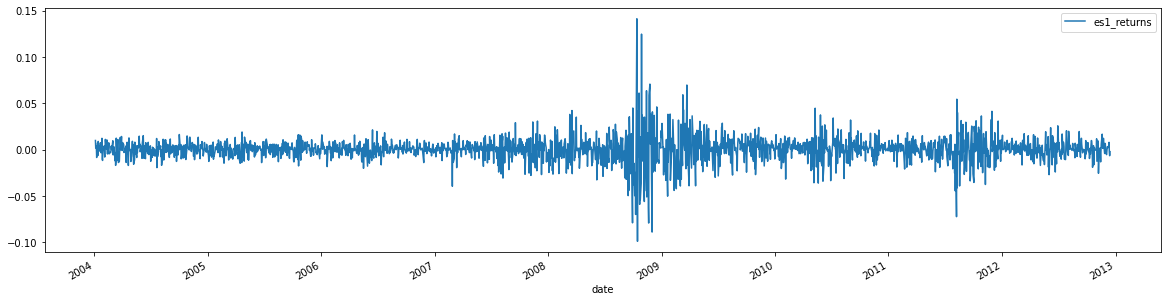

In [3]:
market_path = os.path.join('data','market',"{}.txt".format(INSTRUMENT))
df_market = pd.read_csv(market_path, sep='\t')
df_market.loc[:, INSTRUMENT_DATE_COLUMN] = pd.to_datetime(df_market[INSTRUMENT_DATE_COLUMN])
df_market = df_market.set_index(INSTRUMENT_DATE_COLUMN)
close = df_market[[INSTRUMENT_PRICE_COLUMN]].dropna()
target = close.pct_change().dropna()
target_name = "{}_returns".format(INSTRUMENT) 
target.columns = [target_name]
target = target[TRAIN_DATE_FIRST: TRAIN_DATE_LAST]

display(Markdown("### {} target data ({} - {})".format(INSTRUMENT,
                                                       TRAIN_DATE_FIRST.split("-")[0],
                                                       TRAIN_DATE_LAST.split("-")[0])))
display(HTML(target.head(5).to_html()))
display(Markdown("#### shape = {}".format(target.shape)))
display(Markdown(" "))
fig, ax = plt.subplots(figsize=(20,5))
target.plot(ax=ax);

## Creating features from google trends data

For a day $t$ and word $w$, ${X^{w}}_t$ is the google tred associated with $w$. We define the word feature ${D^{w}}_t$ as the $k$ difference:

\begin{equation}
{D^{w}}_t = {X^{w}}_t - {X^{w}}_{t-k}
\end{equation}

### Google trends data (2004 - 2012)

,BUY_AND_HOLD,DOW_JONES,act,arts,bank,banking,blacklist,bonds,bubble,business,buy,cancer,car,carolina,case,cash,ceo,chance,college,color,committee,community,companies,conflict,consume,consumption,conty,corporation,council,county,court,crash,credit,crisis,culture,debt,default,democratic,derivatives,development,district,dividend,dow_jones,earnings,earths,economic,economics,economy,elected,election,elections,energy,environment,fed,federal,finance,financial,fine,firm,fond,food,forex,founded,freedom,fun,gain,gains,garden,georgia,global,gold,government,governor,greed,growth,happy,headlines,health,hedge,holiday,home,house,housing,illinois,inc,industry,inflation,invest,investment,judge,justice,kentucky,kitchen,labor,law,legal,leverage,lifestyle,loss,ltd,management,market,marketing,markets,marriage,massachusetts,media,members,metals,million,minister,ministry,missouri,money,movement,movie,nasdaq,notability,nyse,office,ohio,oil,opportunity,ore,party,pennsylvania,police,political,politics,portfolio,present,president,products,profit,project,rare,religion,representatives,republican,restaurant,return,returns,revenue,rich,rights,ring,risk,seats,secretary,security,sell,selling,senate,served,service,services,short,social,society,stats,stock,stocks,success,technology,tennessee,texas,tourism,trader,train,transaction,travel,unemployment,union,vermont,vermount,virginia,voter,voters,votes,war,washington,water,william,winsconsin,wisconsin,world,york
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2004-01-08,0.0,1.0,15.0,3.0,28.0,3.0,0.0,-4.0,0.0,24.0,-22.0,9.0,-1.0,-5.0,-7.0,-2.0,3.0,0.0,27.0,7.0,2.0,24.0,5.0,0.0,0.0,1.0,1.0,14.0,8.0,32.0,23.0,-2.0,11.0,1.0,7.0,1.0,2.0,1.0,0.0,15.0,28.0,1.0,2.0,1.0,0.0,5.0,-2.0,1.0,1.0,1.0,2.0,10.0,2.0,1.0,19.0,7.0,15.0,-4.0,5.0,1.0,-8.0,0.0,0.0,-3.0,-4.0,-3.0,1.0,-6.0,10.0,10.0,-2.0,20.0,2.0,0.0,0.0,-11.0,2.0,38.0,1.0,-11.0,-16.0,-4.0,5.0,14.0,18.0,9.0,0.0,1.0,3.0,2.0,4.0,-3.0,-12.0,9.0,26.0,5.0,1.0,-1.0,7.0,2.0,26.0,4.0,12.0,2.0,4.0,0.0,-2.0,-1.0,0.0,-2.0,1.0,1.0,-1.0,2.0,4.0,-50.0,3.0,0.0,2.0,27.0,5.0,-2.0,0.0,0.0,-2.0,4.0,4.0,6.0,1.0,-3.0,1.0,10.0,9.0,1.0,13.0,1.0,2.0,1.0,1.0,-2.0,-12.0,-2.0,6.0,2.0,10.0,-10.0,3.0,-3.0,8.0,22.0,2.0,1.0,3.0,0.0,10.0,29.0,2.0,16.0,3.0,-1.0,9.0,-1.0,2.0,13.0,2.0,8.0,0.0,-7.0,-4.0,0.0,-2.0,2.0,3.0,-11.0,0.0,9.0,1.0,1.0,0.0,24.0,24.0,2.0,14.0,0.0,2.0,1.0,10.0
2004-01-09,0.0,0.0,11.0,2.0,-6.0,2.0,-2.0,0.0,3.0,8.0,-20.0,9.0,-1.0,3.0,0.0,0.0,2.0,0.0,-3.0,5.0,3.0,5.0,8.0,-1.0,0.0,0.0,1.0,9.0,3.0,6.0,10.0,-3.0,-2.0,0.0,5.0,0.0,-1.0,3.0,0.0,9.0,15.0,0.0,-1.0,1.0,0.0,3.0,2.0,1.0,1.0,3.0,1.0,4.0,3.0,1.0,-3.0,3.0,0.0,-1.0,1.0,0.0,9.0,0.0,2.0,1.0,-1.0,0.0,-1.0,-4.0,2.0,6.0,-5.0,4.0,2.0,-1.0,3.0,-7.0,0.0,10.0,0.0,-4.0,-25.0,-13.0,4.0,-3.0,10.0,2.0,-1.0,0.0,1.0,3.0,1.0,-1.0,-5.0,4.0,6.0,4.0,-1.0,-1.0,0.0,0.0,14.0,1.0,5.0,0.0,-3.0,-4.0,0.0,1.0,0.0,1.0,0.0,0.0,-4.0,-3.0,3.0,-31.0,0.0,0.0,1.0,8.0,1.0,-1.0,0.0,-1.0,-2.0,-3.0,1.0,4.0,0.0,1.0,0.0,10.0,0.0,0.0,11.0,-2.0,5.0,3.0,3.0,11.0,-11.0,1.0,3.0,0.0,7.0,-5.0,4.0,-3.0,2.0,3.0,0.0,0.0,4.0,0.0,-14.0,5.0,2.0,5.0,5.0,3.0,-3.0,-3.0,1.0,11.0,5.0,-3.0,1.0,-2.0,-2.0,0.0,-5.0,1.0,-4.0,-1.0,0.0,5.0,0.0,0.0,0.0,15.0,7.0,0.0,9.0,-1.0,0.0,-10.0,-2.0
2004-01-10,0.0,0.0,3.0,1.0,-5.0,-1.0,0.0,0.0,-1.0,5.0,-8.0,-1.0,0.0,10.0,-7.0,3.0,-1.0,-2.0,3.0,0.0,-1.0,4.0,2.0,-1.0,0.0,0.0,0.0,6.0,4.0,1.0,4.0,-7.0,-3.0,-2.0,1.0,2.0,-3.0,1.0,0.0,-2.0,1.0,-1.0,-1.0,1.0,1.0,3.0,-1.0,-3.0,0.0,0.0,2.0,4.0,0.0,0.0,3.0,2.0,5.0,0.0,2.0,0.0,3.0,0.0,0.0,-1.0,4.0,-6.0,0.0,4.0,0.0,-2.0,-2.0,-2.0,1.0,1.0,2.0,-2.0,0.0,-1.0,1.0,-3.0,3.0,-6.0,3.0,-8.0,2.0,-3.0,1.0,0.0,0.0,0.0,0.0,-2.0,-3.0,4.0,2.0,2.0,1.0,1.0,-1.0,-2.0,2.0,-7.0,1.0,-1.0,0.0,-9.0,12.0,-3.0,1.0,3.0,-1.0,-1.0,-6.0,-2.0,-2.0,-11.0,-1.0,0.0,1.0,4.0,-4.0,0.0,1.0,0.0,-1.0,-7.0,2.0,1.0,2.0,-1.0,1.0,-1.0,-5.0,0.0,3.0,1.0,-1.0,-1.0,-2.0,11.0,-8.0,-1.0,-1.0,-3.0,5.0,-8.0,0.0,-1.0,2.0,2.0,3.0,1.0,2

#### shape = (3266, 187)

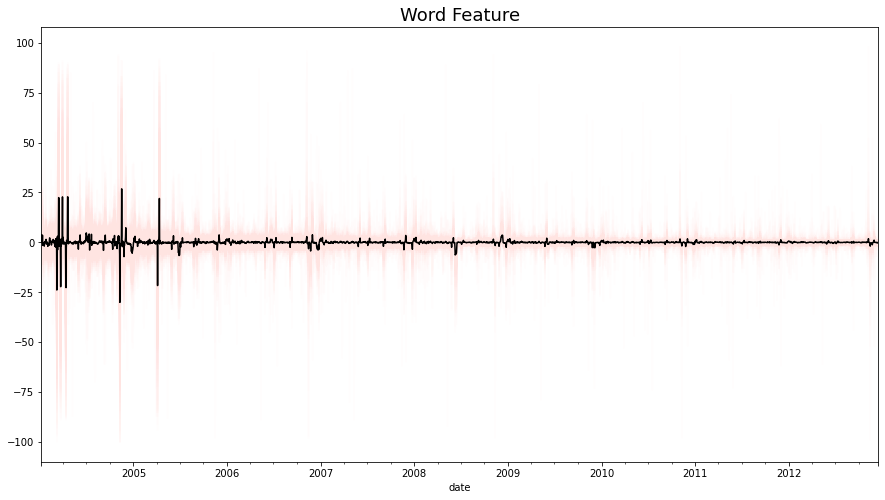

In [4]:
trends_path = os.path.join('data','daily_trend',"*.csv")
daily_dfs_path =  glob(trends_path)
daily_dfs_path.sort()
daily_dfs = [pd.read_csv(path) for path in daily_dfs_path]
daily_dfs_names = [i.split("/")[2] for i in daily_dfs_path]
daily_dfs_names = [i.split(".")[0] for i in daily_dfs_names]

trends = []
for name, df in zip(daily_dfs_names, daily_dfs):
    df.index = pd.to_datetime(df.date)
    ts = df[name]
    new_name = name.replace(" ", "_")
    ts.name = new_name
    trends.append(ts)

trends = pd.concat(trends,1)
trends = trends.fillna(0.0)
trends = trends.diff(K).dropna()
word_features = list(trends.columns)
word_features.sort()
trends = trends[word_features]
trends = trends[TRAIN_DATE_FIRST: TRAIN_DATE_LAST]


display(Markdown("### Google trends data ({} - {})".format(TRAIN_DATE_FIRST.split("-")[0],
                                                           TRAIN_DATE_LAST.split("-")[0])))
display(HTML(trends.head(5).to_html()))
display(Markdown("#### shape = {}".format(trends.shape))) 

fig, ax = plt.subplots(figsize=(15,8))
trends.plot(ax=ax,legend=False,alpha= 0.05,  color="mistyrose");
trends.mean(1).plot(ax=ax,legend=False, color="k", label="mean trend");
ax.set_title("Word Feature", fontsize=18);

## Merging both datasets

In [5]:
merged_df = pd.merge_asof(trends, target, left_index=True, right_index=True)
merged_df.loc[:, target_name] = merged_df[target_name]
merged_df = merged_df.dropna()

# 'global' and 'return' causes problems the smf.ols method
# merged_df = merged_df.rename(columns={"global":"global_","return":"return_"})
word_features = [w for w in merged_df.columns if w != target_name]
merged_df = merged_df[[target_name] + word_features]

display(Markdown("### Merged data ({} - {})".format(TRAIN_DATE_FIRST.split("-")[0],
                                                           TRAIN_DATE_LAST.split("-")[0])))
display(HTML(merged_df.head(5).to_html()))
display(Markdown("#### shape = {}".format(merged_df.shape))) 

### Merged data (2004 - 2012)

,es1_returns,BUY_AND_HOLD,DOW_JONES,act,arts,bank,banking,blacklist,bonds,bubble,business,buy,cancer,car,carolina,case,cash,ceo,chance,college,color,committee,community,companies,conflict,consume,consumption,conty,corporation,council,county,court,crash,credit,crisis,culture,debt,default,democratic,derivatives,development,district,dividend,dow_jones,earnings,earths,economic,economics,economy,elected,election,elections,energy,environment,fed,federal,finance,financial,fine,firm,fond,food,forex,founded,freedom,fun,gain,gains,garden,georgia,global,gold,government,governor,greed,growth,happy,headlines,health,hedge,holiday,home,house,housing,illinois,inc,industry,inflation,invest,investment,judge,justice,kentucky,kitchen,labor,law,legal,leverage,lifestyle,loss,ltd,management,market,marketing,markets,marriage,massachusetts,media,members,metals,million,minister,ministry,missouri,money,movement,movie,nasdaq,notability,nyse,office,ohio,oil,opportunity,ore,party,pennsylvania,police,political,politics,portfolio,present,president,products,profit,project,rare,religion,representatives,republican,restaurant,return,returns,revenue,rich,rights,ring,risk,seats,secretary,security,sell,selling,senate,served,service,services,short,social,society,stats,stock,stocks,success,technology,tennessee,texas,tourism,trader,train,transaction,travel,unemployment,union,vermont,vermount,virginia,voter,voters,votes,war,washington,water,william,winsconsin,wisconsin,world,york
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2004-01-08,0.003556,0.0,1.0,15.0,3.0,28.0,3.0,0.0,-4.0,0.0,24.0,-22.0,9.0,-1.0,-5.0,-7.0,-2.0,3.0,0.0,27.0,7.0,2.0,24.0,5.0,0.0,0.0,1.0,1.0,14.0,8.0,32.0,23.0,-2.0,11.0,1.0,7.0,1.0,2.0,1.0,0.0,15.0,28.0,1.0,2.0,1.0,0.0,5.0,-2.0,1.0,1.0,1.0,2.0,10.0,2.0,1.0,19.0,7.0,15.0,-4.0,5.0,1.0,-8.0,0.0,0.0,-3.0,-4.0,-3.0,1.0,-6.0,10.0,10.0,-2.0,20.0,2.0,0.0,0.0,-11.0,2.0,38.0,1.0,-11.0,-16.0,-4.0,5.0,14.0,18.0,9.0,0.0,1.0,3.0,2.0,4.0,-3.0,-12.0,9.0,26.0,5.0,1.0,-1.0,7.0,2.0,26.0,4.0,12.0,2.0,4.0,0.0,-2.0,-1.0,0.0,-2.0,1.0,1.0,-1.0,2.0,4.0,-50.0,3.0,0.0,2.0,27.0,5.0,-2.0,0.0,0.0,-2.0,4.0,4.0,6.0,1.0,-3.0,1.0,10.0,9.0,1.0,13.0,1.0,2.0,1.0,1.0,-2.0,-12.0,-2.0,6.0,2.0,10.0,-10.0,3.0,-3.0,8.0,22.0,2.0,1.0,3.0,0.0,10.0,29.0,2.0,16.0,3.0,-1.0,9.0,-1.0,2.0,13.0,2.0,8.0,0.0,-7.0,-4.0,0.0,-2.0,2.0,3.0,-11.0,0.0,9.0,1.0,1.0,0.0,24.0,24.0,2.0,14.0,0.0,2.0,1.0,10.0
2004-01-09,-0.008413,0.0,0.0,11.0,2.0,-6.0,2.0,-2.0,0.0,3.0,8.0,-20.0,9.0,-1.0,3.0,0.0,0.0,2.0,0.0,-3.0,5.0,3.0,5.0,8.0,-1.0,0.0,0.0,1.0,9.0,3.0,6.0,10.0,-3.0,-2.0,0.0,5.0,0.0,-1.0,3.0,0.0,9.0,15.0,0.0,-1.0,1.0,0.0,3.0,2.0,1.0,1.0,3.0,1.0,4.0,3.0,1.0,-3.0,3.0,0.0,-1.0,1.0,0.0,9.0,0.0,2.0,1.0,-1.0,0.0,-1.0,-4.0,2.0,6.0,-5.0,4.0,2.0,-1.0,3.0,-7.0,0.0,10.0,0.0,-4.0,-25.0,-13.0,4.0,-3.0,10.0,2.0,-1.0,0.0,1.0,3.0,1.0,-1.0,-5.0,4.0,6.0,4.0,-1.0,-1.0,0.0,0.0,14.0,1.0,5.0,0.0,-3.0,-4.0,0.0,1.0,0.0,1.0,0.0,0.0,-4.0,-3.0,3.0,-31.0,0.0,0.0,1.0,8.0,1.0,-1.0,0.0,-1.0,-2.0,-3.0,1.0,4.0,0.0,1.0,0.0,10.0,0.0,0.0,11.0,-2.0,5.0,3.0,3.0,11.0,-11.0,1.0,3.0,0.0,7.0,-5.0,4.0,-3.0,2.0,3.0,0.0,0.0,4.0,0.0,-14.0,5.0,2.0,5.0,5.0,3.0,-3.0,-3.0,1.0,11.0,5.0,-3.0,1.0,-2.0,-2.0,0.0,-5.0,1.0,-4.0,-1.0,0.0,5.0,0.0,0.0,0.0,15.0,7.0,0.0,9.0,-1.0,0.0,-10.0,-2.0
2004-01-10,-0.008413,0.0,0.0,3.0,1.0,-5.0,-1.0,0.0,0.0,-1.0,5.0,-8.0,-1.0,0.0,10.0,-7.0,3.0,-1.0,-2.0,3.0,0.0,-1.0,4.0,2.0,-1.0,0.0,0.0,0.0,6.0,4.0,1.0,4.0,-7.0,-3.0,-2.0,1.0,2.0,-3.0,1.0,0.0,-2.0,1.0,-1.0,-1.0,1.0,1.0,3.0,-1.0,-3.0,0.0,0.0,2.0,4.0,0.0,0.0,3.0,2.0,5.0,0.0,2.0,0.0,3.0,0.0,0.0,-1.0,4.0,-6.0,0.0,4.0,0.0,-2.0,-2.0,-2.0,1.0,1.0,2.0,-2.0,0.0,-1.0,1.0,-3.0,3.0,-6.0,3.0,-8.0,2.0,-3.0,1.0,0.0,0.0,0.0,0.0,-2.0,-3.0,4.0,2.0,2.0,1.0,1.0,-1.0,-2.0,2.0,-7.0,1.0,-1.0,0.0,-9.0,12.0,-3.0,1.0,3.0,-1.0,-1.0,-6.0,-2.0,-2.0,-11.0,-1.0,0.0,1.0,4.0,-4.0,0.0,1.0,0.0,-1.0,-7.0,2.0,1.0,2.0,-1.0,1.0,-1.0,-5.0,0.0,3.0,1.0,-1.0,-1.0,-2.0,11.0,-8.0,-1.0,-1.

#### shape = (3266, 188)

## Lag Correlation

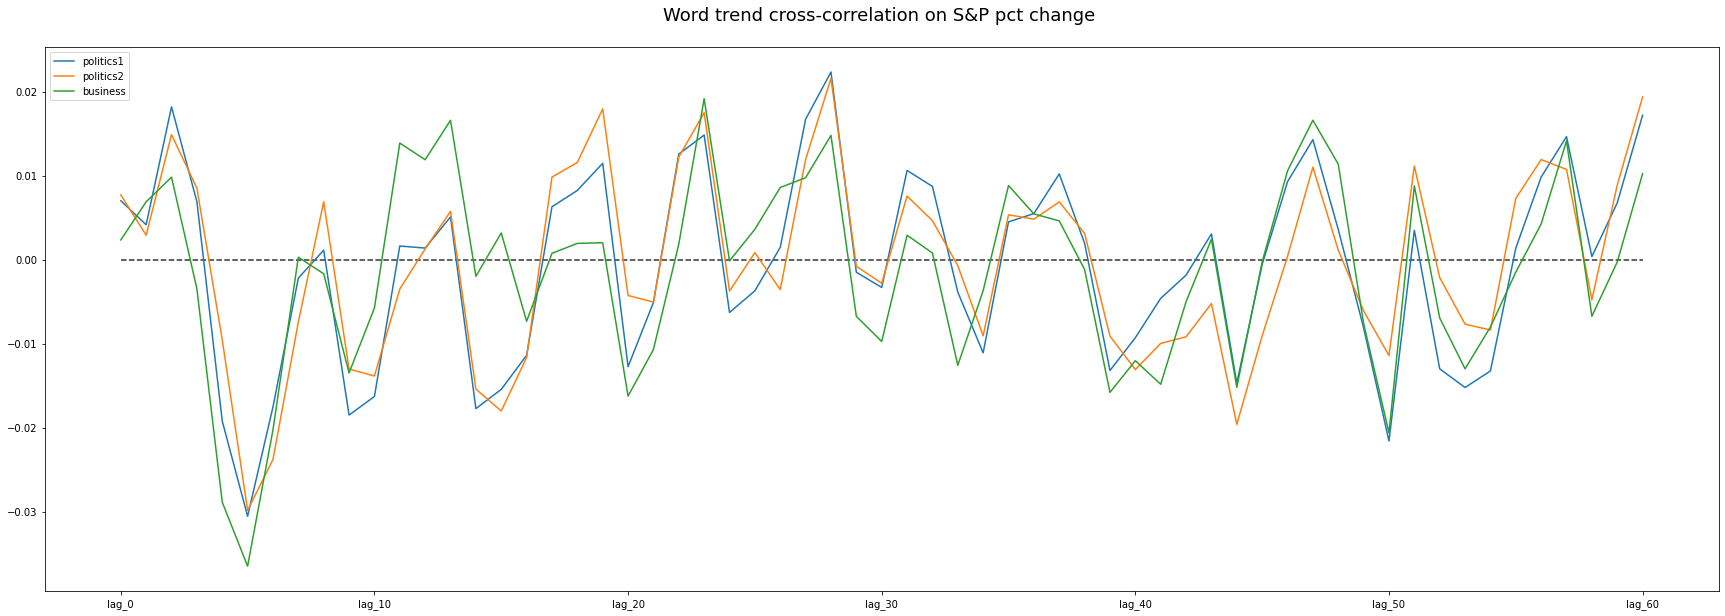

In [6]:
ts1 = merged_df[politics1].mean(1)
ts1.name = "politics1"
ts2 = merged_df[politics2].mean(1)
ts2.name = "politics2"
ts3 = merged_df[business].mean(1)
ts3.name = "business"

lead_series = [ts1, ts2, ts3]
target_ts = merged_df[target_name]

lead_m = get_lead_matrix(lead_series, target_ts, 60)
lead_m = lead_m.transpose()

fig, ax = plt.subplots(figsize=(30,10))
ax.set_title("Word trend cross-correlation on S&P pct change \n", fontsize=18)
lead_m.plot(ax=ax);
ax.hlines(0,0,60, color="k", linestyle="--", alpha=0.8);

In [7]:
lead_m.head(10)

,politics1,politics2,business
lag_0,0.007011,0.007703,0.002339
lag_1,0.004151,0.002902,0.006884
lag_2,0.018192,0.014882,0.009820
lag_3,0.006903,0.008515,-0.003471
lag_4,-0.019226,-0.009544,-0.028884
lag_5,-0.030560,-0.029859,-0.036505
lag_6,-0.017537,-0.023797,-0.020265
lag_7,-0.002201,-0.007440,0.000292
lag_8,0.001123,0.006907,-0.001687
lag_9,-0.018512,-0.013026,-0.013495
